In [1]:
from abc import ABC, abstractmethod
from typing import Optional, List, Type, Tuple, Dict
import math

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes._axes import Axes
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
from tqdm import tqdm
from torchvision.utils import make_grid


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


The dataset I will be using is CelebFaces, which consists of images of celebrity faces. For this project, I will use approximately 60,000 images. The ultimate goal is to learn a vector field that enables the generation of images from the distribution of human celebrity faces, starting from Gaussian noise and evolving through the simulation of an ODE. 

In [2]:
import os
import io
from PIL import Image
import zipfile

# Path to the zip file containing the CelebA dataset
zip_file_path = "/content/celebfaces.zip"

# Function to resize images
def resize_images(zip_file_path, target_size=(64, 64)):
    X_train = []
    # Open the ZIP file
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        # Loop through each file in the zip
        for file_name in zip_ref.namelist():
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                with zip_ref.open(file_name) as file:
                    # Open image and resize
                    image = Image.open(file)
                    resized_image = image.resize(target_size)
                    X_train.append(resized_image)
                    # Convert image to numpy array and append to X_train
                    # X_train.append(np.array(resized_img))
    return X_train

# Resize images and store them in X_train
images = resize_images(zip_file_path)
print("Number of resized images:", len(images))
# images = np.array(images)/ 255.0

Number of resized images: 59056


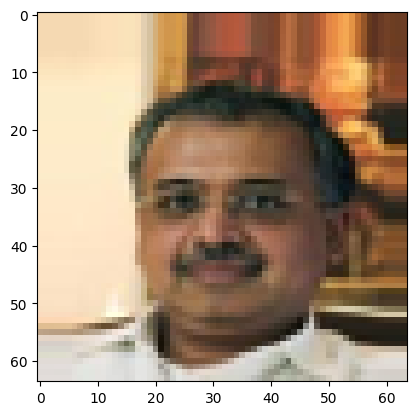

In [3]:
#An example of image in this dataset :
plt.imshow(images[0])

In this cell, I will implement everything needed, starting from the Gaussian distribution and the Gaussian probability decay paths (alpha and beta), as well as all the sampling methods required along this path. I will also define the target conditional vector field and the conditional score, although the score won't be used in this notebook since we are not relying on an SDE-based approach .

In [4]:
class Sampleable(ABC):
    """
    Distribution from which we can sample .
    """
    @abstractmethod #necessary for all subclasses
    def sample(self , num_samples : int) -> torch.Tensor :
        """
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: shape (batch_size, ...)
        """
        pass

class GaussianIsotropic(nn.Module, Sampleable):
    """
        shape: shape of sampled data
        """
    def __init__(self, shape : List[int] ,std : float = 1.0 ) :
        super().__init__()
        self.shape = shape
        self.std = std
        self.dummy = nn.Buffer(torch.zeros(1)) #to keep the same device

    def sample(self, num_samples : int) -> torch.Tensor :
        return (self.std**2)*torch.randn(num_samples, *self.shape).to(self.dummy.device)

class LinearAlpha :
    """
    Implements alpha_t = t
    """
    def __call__(self , t : torch.Tensor) -> torch.Tensor:
        """
        Args:
            - t: time (num_samples, 1, 1, 1) -- to avoid problems with broadcasting
        Returns:
            - alpha_t (num_samples, 1, 1, 1)
        """
        return t

    def dt(self, t : torch.Tensor) :
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1, 1, 1)
        """
        return torch.ones_like(t)

class LinearBeta :
    """
    Implements beta_t = 1 - t
    """
    def __call__(self , t : torch.Tensor) -> torch.Tensor:
        """
        Args:
            - t: time (num_samples, 1, 1, 1) -- to avoid problems with broadcasting
        Returns:
            - beta_t (num_samples, 1, 1, 1)
        """
        return 1 - t

    def dt(self, t : torch.Tensor) :
        """
        Evaluates d/dt beta_t.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - d/dt beta_t (num_samples, 1, 1, 1)
        """
        return -torch.ones_like(t)

class GaussianConditionalProbabilityPath(nn.Module):
    def __init__(self , p_data : Sampleable ,p_simple_shape: List[int], alpha : LinearAlpha , beta : LinearBeta ) :
        super().__init__()
        self.p_simple = GaussianIsotropic(p_simple_shape)
        self.p_data = p_data
        self.alpha = alpha
        self.beta = beta

    def sample_marginal_path(self, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the marginal distribution p_t(x) = p_t(x|z) p(z)
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - x: samples from p_t(x), (num_samples, c, h, w)
        """
        num_samples = t.size(0)
        # Sample conditioning variable z ~ p(z)
        z = self.sample_conditioning_variable(num_samples) # (num_samples, c, h, w)
        # Sample conditional probability path x ~ p_t(x|z)
        x = self.sample_conditional_path(z, t) # (num_samples, c, h, w)
        return x

    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
        """
        Samples the conditioning variable z
        Args:
            - num_samples: the number of samples
        Returns:
            - z: (num_samples, c, h, w)
        """

        return self.p_data.sample(num_samples) #(num_samples, c, h, w)


    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the conditional distribution p_t(x|z)
        Args:
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - x: samples from p_t(x|z), (num_samples, c, h, w)
        """
        return self.alpha(t)*z + self.beta(t)*torch.randn_like(z)

    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional vector field u_t(x|z)
        Args:
            - x: position variable (num_samples, c, h, w)
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - conditional_vector_field: conditional vector field (num_samples, c, h, w)
        """
        alpha_t = self.alpha(t) # (num_samples, 1, 1, 1)
        beta_t = self.beta(t) # (num_samples, 1, 1, 1)
        dt_alpha_t = self.alpha.dt(t) # (num_samples, 1, 1, 1)
        dt_beta_t = self.beta.dt(t) # (num_samples, 1, 1, 1)

        return (dt_alpha_t - dt_beta_t / beta_t * alpha_t) * z + dt_beta_t / beta_t * x


    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional score of p_t(x|z)
        Args:
            - x: position variable (num_samples, c, h, w)
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - conditional_score: conditional score (num_samples, c, h, w)
        """
        alpha_t = self.alpha(t)
        beta_t = self.beta(t)
        return (z * alpha_t - x) / beta_t ** 2



I will wrap the CelebFaces dataset with the Sampleable interface defined above, which will allow us to sample images following the $p_{data}$ distribution.

In [5]:
class CelebFacesSampler(nn.Module, Sampleable):
    """
    Sampleable wrapper for the MNIST dataset
    """
    def __init__(self , dataset):
        super().__init__()
        transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            transforms.ToTensor(),                        # Now shape: (1, H, W)
        ])


        gray_dataset = [transform(img) for img in dataset]  # Each is (1, H, W)
        self.dataset = torch.stack(gray_dataset) #  shape (N, 1, H, W)
        self.dummy = nn.Buffer(torch.zeros(1)) # for device

    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: shape (batch_size, c, h, w)
            - labels: shape (batch_size, label_dim)
        """
        if num_samples > len(self.dataset):
            raise ValueError(f"num_samples exceeds dataset size: {len(self.dataset)}")

        indices = torch.randperm(len(self.dataset))[:num_samples]
        samples = self.dataset[indices].to(self.dummy)
        return samples



The core idea behind this particular type of diffusion model is to use ODE simulation to generate new samples. That’s why we’ll use the ODE and EulerSimulator classes — they simplify the sampling process during generation.

In [6]:
class ODE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, c, h, w)
            - t: time, shape (bs, 1)
        Returns:
            - drift_coefficient: shape (bs, c, h, w)
        """
        pass

class EulerSimulator:
    def __init__(self, ode: ODE):
        self.ode = ode

    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor):
        """
        Takes one simulation step
        Args:
            - xt: state at time t, shape (bs, c, h, w)
            - t: time, shape (bs, 1, 1, 1)
            - dt: time, shape (bs, 1, 1, 1)
        Returns:
            - nxt: state at time t + dt (bs, c, h, w)
        """
        return xt + self.ode.drift_coefficient(xt,t) * h


    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state, shape (bs, c, h, w)
            - ts: timesteps, shape (bs, nts, 1, 1, 1)
        Returns:
            - x_final: final state at time ts[-1], shape (bs, c, h, w)
        """
        nts = ts.shape[1]
        for t_idx in tqdm(range(nts - 1)):
            t = ts[:, t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h)
        return x

    @torch.no_grad()
    def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x: initial state, shape (bs, c, h, w)
            - ts: timesteps, shape (bs, nts, 1, 1, 1)
        Returns:
            - xs: trajectory of xts over ts, shape (batch_size, nts, c, h, w)
        """
        xs = [x.clone()]
        nts = ts.shape[1]
        for t_idx in tqdm(range(nts - 1)):
            t = ts[:,t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h)
            xs.append(x.clone())
        return torch.stack(xs, dim=1)



In [7]:
class ConditionalVectorField(nn.Module, ABC):
    """
    MLP-parameterization of the learned vector field u_t^theta(x)
    """

    @abstractmethod
    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        Args:
        - x: (bs, c, h, w)
        - t: (bs, 1, 1, 1)
        Returns:
        - u_t^theta(x): (bs, c, h, w)
        """
        pass

class CFGVectorFieldODE(ODE):
    def __init__(self, net: ConditionalVectorField):
        self.net = net

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c, h, w)
        - t: (bs, 1, 1, 1)
        """
        vector_field = self.net(x, t)
        return vector_field


Now for the training part: we will train our vector field (net), using MSE loss between the network’s output and the conditional vector field of the Gaussian path — after sampling the time $t$, the latent variable $z$ from the $p_{data}$, and the point $x$ along the conditional path and time $t$.

In [8]:
class Trainer:
    def __init__(self, path : GaussianConditionalProbabilityPath, model: ConditionalVectorField):
        self.path = path
        self.model = model

    def get_train_loss(self, batch_size: int) -> torch.Tensor:
        # Step 1: Sample z from p_data
        z = self.path.p_data.sample(batch_size)    # (bs,c,h,w)

        # Step 2: Sample t and x
        t = torch.rand((batch_size,1,1,1)).to(z.device) # (bs,c,h,w)
        x = self.path.sample_conditional_path(z,t) # (bs,c,h,w)

        # Step 3: Regress and output loss
        u_target = self.path.conditional_vector_field(x,z,t) # (bs,c,h,w)
        u_theta = self.model(x,t) # (bs,c,h,w)

        return torch.mean( (u_target - u_theta).view(batch_size,-1).pow(2).sum(dim = -1))
    
    def get_optimizer(self, lr: float):
        return torch.optim.Adam(self.model.parameters(), lr=lr)

    def train(self, num_epochs: int, batch_size: int,  device: torch.device, lr: float = 1e-3) -> torch.Tensor:
        # Start
        self.model.to(device)
        opt = self.get_optimizer(lr)
        self.model.train()

        # Train loop
        pbar = tqdm(enumerate(range(num_epochs)))
        for idx, epoch in pbar:
            opt.zero_grad()
            loss = self.get_train_loss(batch_size)
            loss.backward()
            opt.step()
            pbar.set_description(f'Epoch {idx}, loss: {loss.item():.3f}')

        # Finish
        self.model.eval()

    def get_train_loss(self, batch_size: int) -> torch.Tensor:
        # Step 1: Sample z from p_data
        z = self.path.p_data.sample(batch_size)    # (bs,c,h,w)

        # Step 2: Sample t and x
        t = torch.rand((batch_size,1,1,1)).to(z.device) # (bs,c,h,w)
        x = self.path.sample_conditional_path(z,t) # (bs,c,h,w)

        # Step 3: Regress and output loss
        u_target = self.path.conditional_vector_field(x,z,t) # (bs,c,h,w)
        u_theta = self.model(x,t) # (bs,c,h,w)

        return torch.mean( (u_target - u_theta).view(batch_size,-1).pow(2).sum(dim = -1))

# U-Net Overview (from how I understood it)

This U-Net architecture wasn't coded by me—it's adapted from an existing implementation I found online. Below is a breakdown of how it works:
- 1. **FourierEncoder (for time)**:
Encodes the timestep \( t \) using fixed Fourier features (i.e., \( \sin(t) \), \( \cos(t) \)) to create a rich time embedding. These embeddings are then added to the input image features, allowing the model to understand temporal information.

- 2. **Label Embedding (for \( y \))**:
The class label \( y \) is embedded using `nn.Embedding`, providing a learnable vector for each label. This helps the model condition the generated output on the class identity.

- 3. **Residual Blocks**:
Each block contains adapters for time and label (via small MLPs), which are added to the output of convolutional layers. These adapters help the model incorporate conditional information at every stage, with skip connections for numerical stability.

- 4. **Encoder**:
A stack of residual blocks that progressively downsample the image (increasing the number of channels while reducing the spatial dimensions), extracting higher-level features at each step.

- 5. **Midcoder**:
A few residual blocks without downsampling. This block operates at the bottleneck of the network, refining the feature representation while maintaining the same spatial dimensions.

- 6. **Decoder**:
Upsamples the features back to the original resolution. It uses standard skip connections along with connections to corresponding encoder outputs, injecting time and label contributions.

- 7. **MNISTUNet**:
Combines all the components above. It starts with an `init_conv` that changes the input shape (1-channel image) into a higher-dimensional feature space (more channels).



In [10]:
class FourierEncoder(nn.Module):
    """
    Based on https://github.com/lucidrains/denoising-diffusion-pytorch/blob/main/denoising_diffusion_pytorch/karras_unet.py#L183
    """
    def __init__(self, dim: int):
        super().__init__()
        assert dim % 2 == 0
        self.half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(1, self.half_dim))

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - t: (bs, 1, 1, 1)
        Returns:
        - embeddings: (bs, dim)
        """
        t = t.view(-1, 1) # (bs, 1)
        freqs = t * self.weights * 2 * math.pi # (bs, half_dim)
        sin_embed = torch.sin(freqs) # (bs, half_dim)
        cos_embed = torch.cos(freqs) # (bs, half_dim)
        return torch.cat([sin_embed, cos_embed], dim=-1) * math.sqrt(2) # (bs, dim)

class ResidualLayer(nn.Module):
    def __init__(self, channels: int, time_embed_dim: int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.SiLU(),
            nn.BatchNorm2d(channels),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )
        self.block2 = nn.Sequential(
            nn.SiLU(),
            nn.BatchNorm2d(channels),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )
        # Converts (bs, time_embed_dim) -> (bs, channels)
        self.time_adapter = nn.Sequential(
            nn.Linear(time_embed_dim, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, channels)
        )


    def forward(self, x: torch.Tensor, t_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c, h, w)
        - t_embed: (bs, t_embed_dim)
        - y_embed: (bs, y_embed_dim)
        """
        res = x.clone() # (bs, c, h, w)

        # Initial conv block
        x = self.block1(x) # (bs, c, h, w)

        # Add time embedding
        t_embed = self.time_adapter(t_embed).unsqueeze(-1).unsqueeze(-1) # (bs, c, 1, 1)
        x = x + t_embed



        # Second conv block
        x = self.block2(x) # (bs, c, h, w)

        # Add back residual
        x = x + res # (bs, c, h, w)

        return x

class Encoder(nn.Module):
    def __init__(self, channels_in: int, channels_out: int, num_residual_layers: int, t_embed_dim: int):
        super().__init__()
        self.res_blocks = nn.ModuleList([
            ResidualLayer(channels_in, t_embed_dim) for _ in range(num_residual_layers)
        ])
        self.downsample = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=2, padding=1)

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c_in, h, w)
        - t_embed: (bs, t_embed_dim)
        """
        # Pass through residual blocks: (bs, c_in, h, w) -> (bs, c_in, h, w)
        for block in self.res_blocks:
            x = block(x, t_embed)

        # Downsample: (bs, c_in, h, w) -> (bs, c_out, h // 2, w // 2)
        x = self.downsample(x)

        return x

class Midcoder(nn.Module):
    def __init__(self, channels: int, num_residual_layers: int, t_embed_dim: int):
        super().__init__()
        self.res_blocks = nn.ModuleList([
            ResidualLayer(channels, t_embed_dim) for _ in range(num_residual_layers)
        ])

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c, h, w)
        - t_embed: (bs, t_embed_dim)
        """
        # Pass through residual blocks: (bs, c, h, w) -> (bs, c, h, w)
        for block in self.res_blocks:
            x = block(x, t_embed)

        return x

class Decoder(nn.Module):
    def __init__(self, channels_in: int, channels_out: int, num_residual_layers: int, t_embed_dim: int):
        super().__init__()
        self.upsample = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear'), nn.Conv2d(channels_in, channels_out, kernel_size=3, padding=1))
        self.res_blocks = nn.ModuleList([
            ResidualLayer(channels_out, t_embed_dim) for _ in range(num_residual_layers)
        ])

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c, h, w)
        - t_embed: (bs, t_embed_dim)
        """
        # Upsample: (bs, c_in, h, w) -> (bs, c_out, 2 * h, 2 * w)
        x = self.upsample(x)

        # Pass through residual blocks: (bs, c_out, h, w) -> (bs, c_out, 2 * h, 2 * w)
        for block in self.res_blocks:
            x = block(x, t_embed)

        return x

class UNet(ConditionalVectorField):
    def __init__(self, channels: List[int], num_residual_layers: int, t_embed_dim: int):
        super().__init__()
        # Initial convolution: (bs, 1, 32, 32) -> (bs, c_0, 32, 32)
        self.init_conv = nn.Sequential(nn.Conv2d(1, channels[0], kernel_size=3, padding=1), nn.BatchNorm2d(channels[0]), nn.SiLU())

        # Initialize time embedder
        self.time_embedder = FourierEncoder(t_embed_dim)

        # Encoders, Midcoders, and Decoders
        encoders = []
        decoders = []
        for (curr_c, next_c) in zip(channels[:-1], channels[1:]):
            encoders.append(Encoder(curr_c, next_c, num_residual_layers, t_embed_dim))
            decoders.append(Decoder(next_c, curr_c, num_residual_layers, t_embed_dim))
        self.encoders = nn.ModuleList(encoders)
        self.decoders = nn.ModuleList(reversed(decoders))

        self.midcoder = Midcoder(channels[-1], num_residual_layers, t_embed_dim)

        # Final convolution
        self.final_conv = nn.Conv2d(channels[0], 1, kernel_size=3, padding=1)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        Args:
        - x: (bs, 1, 32, 32)
        - t: (bs, 1, 1, 1)
        - y: (bs,)
        Returns:
        - u_t^theta(x|y): (bs, 1, 32, 32)
        """
        # Embed t and y
        t_embed = self.time_embedder(t) # (bs, time_embed_dim)

        # Initial convolution
        x = self.init_conv(x) # (bs, c_0, 64,64)

        residuals = []

        # Encoders
        for encoder in self.encoders:
            x = encoder(x, t_embed) # (bs, c_i, h, w) -> (bs, c_{i+1}, h // 2, w //2)
            residuals.append(x.clone())

        # Midcoder
        x = self.midcoder(x, t_embed)

        # Decoders
        for decoder in self.decoders:
            res = residuals.pop() # (bs, c_i, h, w)
            x = x + res
            x = decoder(x, t_embed) # (bs, c_i, h, w) -> (bs, c_{i-1}, 2 * h, 2 * w)

        # Final convolution
        x = self.final_conv(x) # (bs, 1, 64 ,64)

        return x

Now, we will define everything and train our model. After more than 1.5 hours on a T4 GPU, we encountered some limitations. The choice of `batch_size` and `num_residual_layers` was constrained by the GPU's 15 GB memory capacity. Despite this, we didn’t achieve excellent results even after 5000 epochs.

Just to clarify, I used a grayscale transformation on all the images, so the model only learned from grayscale images with shape \( (1, 64, 64) \), which should be easier than working with RGB images.


In [ ]:
# Initialize probability path
path = GaussianConditionalProbabilityPath(
    p_data = CelebFacesSampler(dataset= images),
    p_simple_shape = [1, 64,64],
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

# Initialize model
unet = UNet(
    channels = [32, 64, 128],
    num_residual_layers = 4,
    t_embed_dim = 40,
)

# Initialize trainer
trainer = Trainer(path = path, model = unet)


# Train
trainer.train(num_epochs = 7000, device=device, lr=1e-3, batch_size= 250)

Epoch 5102, loss: 444.247: : 5103it [1:31:42,  1.08s/it]


KeyboardInterrupt: 

100%|██████████| 99/99 [00:02<00:00, 35.53it/s]


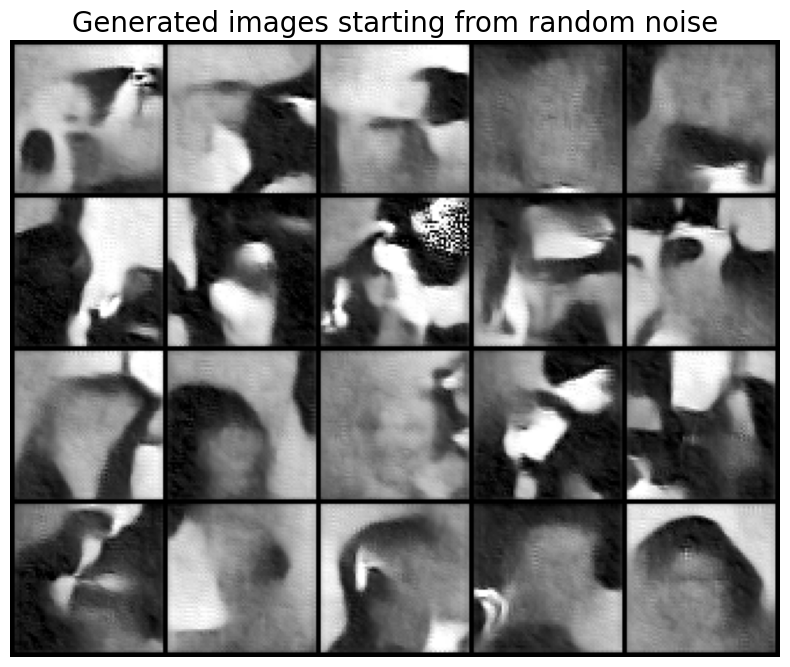

In [12]:
num_timesteps = 100


# Setup ode and simulator
ode = CFGVectorFieldODE(unet)
simulator = EulerSimulator(ode)


# Sample initial conditions
num_samples = 20
x0 = path.p_simple.sample(num_samples)  # (num_samples, 1, 32, 32)

# Simulate
ts = torch.linspace(0, 1, num_timesteps).view(1, -1, 1, 1, 1).expand(num_samples, -1, 1, 1, 1).to(device)
x1 = simulator.simulate(x0, ts)  # Shape: (num_samples, 1, 32, 32)


# Create image grid
grid = make_grid(x1, nrow=5, padding=2)

# Plot
fig, axes = plt.subplots(figsize=(8, 10))
axes.imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
axes.axis("off")
axes.set_title("Generated images starting from random noise", fontsize=20)
plt.tight_layout()
plt.show()



As we can see in these generated images, the model tends to learn the shape of the human face and hair, showing that it’s starting to learn something meaningful. However, at a certain point, the model becomes stationary, with no further learning occurring. I don't believe that U-Net will be sufficient or efficient, especially with the memory constraints. Therefore, it’s better to explore models (such as attention-based models) that incorporate specific non-linearities, which may help the model learn more quickly and efficiently.

In [ ]:
# An image example after gray transform :
plt.imshow(path.p_data.sample(1).squeeze(0).squeeze(0).cpu()  , cmap='gray')

### Next Steps:
Try a new transformer-based architecture, as the U-Net model didn't provide good results even after 2 hours of training.